# PI-II: Demo QRF

A simple example of fitting a quantile regression forest (QRF) using the [quantile-forest](https://zillow.github.io/quantile-forest/) package to estimate prediction intervals.

Starter script for the [Prediction interval competition II: House price](https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price/overview) competition.

In [1]:
!pip install -q quantile-forest 2>/dev/null  # package for quantile regression forests

In [13]:
import numpy as np
import pandas as pd
from quantile_forest import RandomForestQuantileRegressor
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

random_state = 0
np.random.seed(random_state)

# Competition variables.
alpha = 0.1  # the specified competition alpha (i.e., 90% coverage)

In [3]:
def winkler_score(y_true, lower, upper, alpha=0.1, return_coverage=False):
    """Compute the Winkler Interval Score for prediction intervals.

    Args:
        y_true (array-like): True observed values.
        lower (array-like): Lower bounds of prediction intervals.
        upper (array-like): Upper bounds of prediction intervals.
        alpha (float): Significance level (e.g., 0.1 for 90% intervals).
        return_coverage (bool): If True, also return empirical coverage.

    Returns:
        score (float): Mean Winkler Score.
        coverage (float, optional): Proportion of true values within intervals.
    """
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)

    width = upper - lower
    penalty_lower = 2 / alpha * (lower - y_true)
    penalty_upper = 2 / alpha * (y_true - upper)

    score = width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)

    if return_coverage:
        inside = (y_true >= lower) & (y_true <= upper)
        coverage = np.mean(inside)
        return np.mean(score), coverage

    return np.mean(score)

In [5]:
df = pd.read_csv("dataset.csv", index_col="id", parse_dates=["sale_date"])
df_test = pd.read_csv( "test.csv", index_col="id", parse_dates=["sale_date"])

## Data Preparation

Prepare the data, including separating features and target, encoding categoricals, imputation, and simple feature engineering.

In [6]:
# Split features and target.
X = df.drop("sale_price", axis=1)
y = df["sale_price"]

# Split train/val and test.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.50, random_state=random_state
)
X_test = df_test.copy()

In [7]:
# Ordinal encoding.
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_val[cat_cols] = encoder.transform(X_val[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

In [8]:
# Imputation.
num_cols = X_train.select_dtypes(include="number").columns.tolist()

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")


def impute(df, cols, imputer, fit=False):
    """Helper function for imputation."""
    if fit:
        return pd.DataFrame(imputer.fit_transform(df[cols]), columns=cols, index=df.index)
    else:
        return pd.DataFrame(imputer.transform(df[cols]), columns=cols, index=df.index)


X_train[num_cols] = impute(X_train, num_cols, num_imputer, fit=True)
X_val[num_cols] = impute(X_val, num_cols, num_imputer)
X_test[num_cols] = impute(X_test, num_cols, num_imputer)

X_train[cat_cols] = impute(X_train, cat_cols, cat_imputer, fit=True)
X_val[cat_cols] = impute(X_val, cat_cols, cat_imputer)
X_test[cat_cols] = impute(X_test, cat_cols, cat_imputer)

In [9]:
class SaleDateEncoder(BaseEstimator, TransformerMixin):
    """Encode sale date as a week of the year feature."""

    def __init__(self, date_column="sale_date"):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.assign(
            **{
                "sale_week": lambda x: x["sale_date"].dt.isocalendar().week,
            }
        ).drop(columns=["sale_date"])
        return X

    def fit_transform(self, X):
        return self.fit(self, X).transform(X)


# Sale date encoding.
saledate_encoder = SaleDateEncoder(date_column="sale_date")
X_train = saledate_encoder.fit_transform(X_train)
X_val = saledate_encoder.transform(X_val)
X_test = saledate_encoder.transform(X_test)

## Model Fitting

Fit a QRF model and use it to estimate a nominal marginal coverage of 90% (quantiles 0.05 and 0.95).

In [10]:
qrf = RandomForestQuantileRegressor(
    n_estimators=100,
    max_features=0.333,
    max_samples_leaf=1,
    random_state=random_state,
)
qrf.fit(X_train, y_train)

,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.333
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [11]:
quantiles = [alpha / 2, 1 - alpha / 2]

y_val_pred = qrf.predict(X_val, quantiles=quantiles)
y_val_pred = pd.DataFrame(y_val_pred, columns=["pi_lower", "pi_upper"])

## Evaluation

Evaluate the QRF predictions on the validation data.

In [12]:
mws, coverage = winkler_score(
    y_val,
    y_val_pred["pi_lower"],
    y_val_pred["pi_upper"],
    alpha=alpha,
    return_coverage=True,
)

print("Mean Winkler Score:", round(mws, 2))
print("Coverage:", round(coverage * 100, 1), "%")

Mean Winkler Score: 878194.71
Coverage: 89.8 %


## Submission

In [ ]:
# Predict intervals on test set.
test_preds = qrf.predict(X_test, quantiles=quantiles)

sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["pi_lower"] = test_preds[:, 0]
sample_submission["pi_upper"] = test_preds[:, 1]
sample_submission.to_csv("submission.csv", index=False)

sample_submission

,id,pi_lower,pi_upper
0,200000,496945.0,990095.0
1,200001,561725.5,1757500.0
2,200002,287800.0,966746.1
3,200003,207972.5,462825.0
4,200004,304750.0,1775000.0
...,...,...,...
199995,399995,213525.0,815000.0
199996,399996,249000.0,743250.0
199997,399997,194795.0,560000.0
199998,399998,376106.8,801050.0


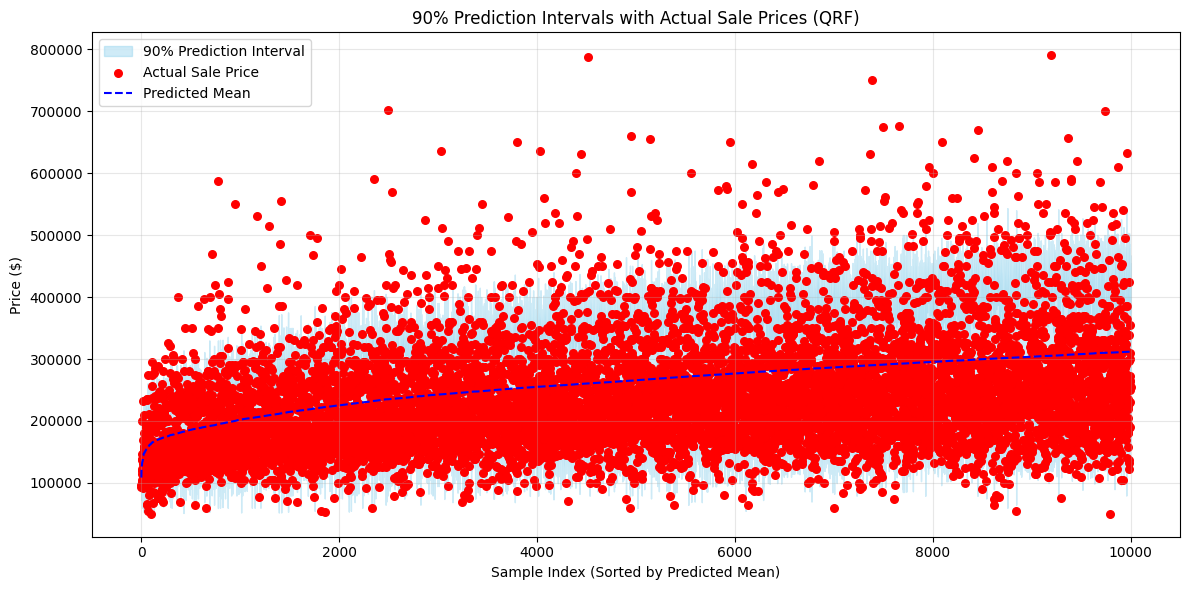

In [15]:
def plot_prediction_intervals(y_true, pi_lower, pi_upper, n_samples=10000):

    pred_mean = (pi_lower + pi_upper) / 2
    indices = np.argsort(pred_mean)[:n_samples]
    pi_lower = pi_lower[indices]
    pi_upper = pi_upper[indices]
    y_true = y_true.iloc[indices].values
    
    plt.figure(figsize=(12, 6))
    x = np.arange(n_samples)
    plt.fill_between(x, pi_lower, pi_upper, color='skyblue', alpha=0.4, label='90% Prediction Interval')
    plt.scatter(x, y_true, color='red', s=30, label='Actual Sale Price')
    plt.plot(x, (pi_lower + pi_upper) / 2, color='blue', linestyle='--', label='Predicted Mean')
    
    plt.xlabel('Sample Index (Sorted by Predicted Mean)')
    plt.ylabel('Price ($)')
    plt.title('90% Prediction Intervals with Actual Sale Prices (QRF)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediction_intervals_qrf.png')
    plt.show()

plot_prediction_intervals(y_val, y_val_pred["pi_lower"], y_val_pred["pi_upper"], n_samples=10000)